In [2]:
# CELL 1: Cài đặt Ultralytics (đã có YOLOv10)
!pip install -q --upgrade ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00:00:0100:01


In [3]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [4]:
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [5]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [6]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

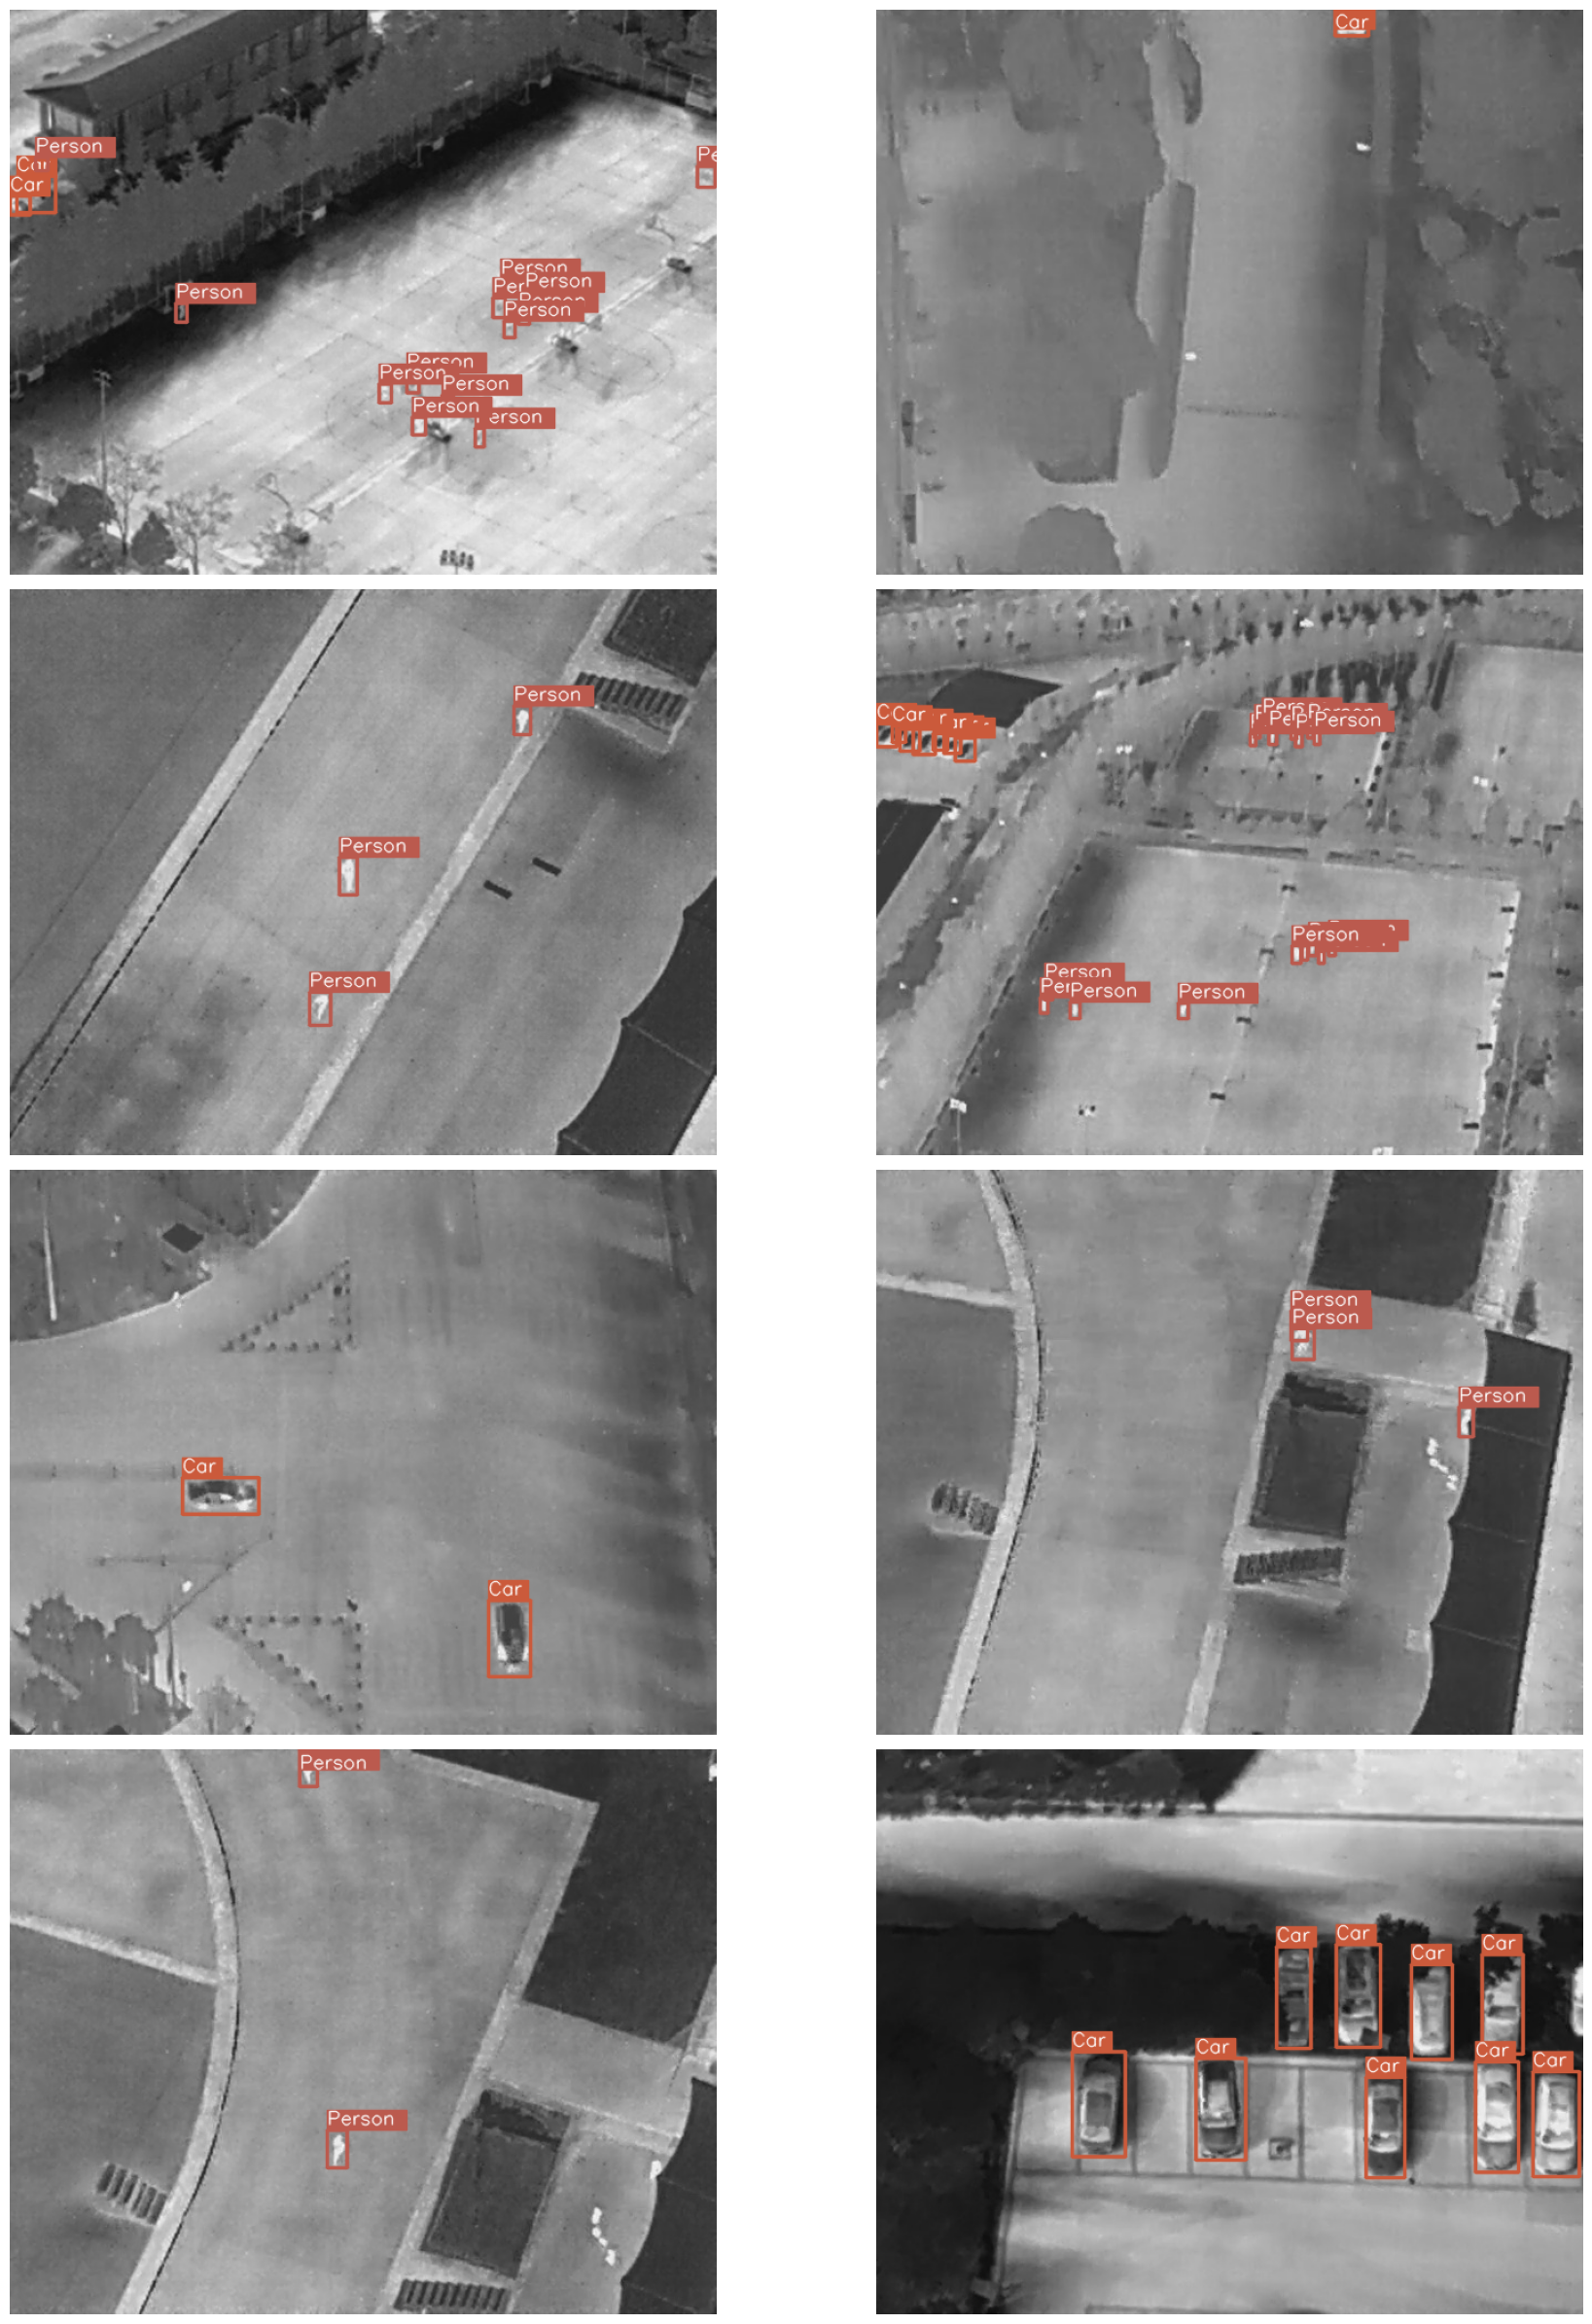

In [8]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [17]:
# CELL 8: Tạo yolov10n_mobilenetv2.yaml (ĐÃ FIX 100% – DỰA TRÊN THỰC TẾ)
import yaml

model_dict = {
    "nc": 5,
    "scales": {"n": [0.33, 0.25, 1024]},

    "backbone": [
        # 0: Load MobileNetV2 từ TorchVision
        [-1, 1, "TorchVision", [1280, "mobilenet_v2", "DEFAULT", True, 2, True]],
        [-1, 1, "nn.Identity", []],  # 1
        [-1, 1, "nn.Identity", []],  # 2

        # P3: 80x80 → layer 6 (32 ch)
        [0, 1, "Index", [32, 6]],           # 32 ch @80x80 → index 3
        [-1, 1, "Conv", [256, 1, 1]],       # 32 → 256 → index 4
        [-1, 1, "nn.Identity", []],         # P3 → index 5

        # P4: 40x40 → layer 13 (96 ch)
        [0, 1, "Index", [96, 13]],          # 96 ch @40x40 → index 6
        [-1, 1, "Conv", [512, 1, 1]],       # 96 → 512 → index 7
        [-1, 1, "nn.Identity", []],         # P4 → index 8

        # P5: 20x20 → layer 18 (320 ch)
        [0, 1, "Index", [320, 18]],         # 320 ch @20x20 → index 9
        [-1, 1, "Conv", [1024, 1, 1]],      # 320 → 1024 → index 10
        [-1, 1, "SPPF", [1024, 5]],         # SPPF → index 11
    ],

    "head": [
        [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
        [[-1, 8], 1, "Concat", [1]],        # + P4
        [-1, 3, "C2f", [512, True]],
        [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
        [[-1, 5], 1, "Concat", [1]],        # + P3
        [-1, 3, "C2f", [256, True]],
        [-1, 1, "Conv", [256, 3, 2]],
        [[-1, 12], 1, "Concat", [1]],
        [-1, 3, "C2f", [512, True]],
        [-1, 1, "Conv", [512, 3, 2]],
        [[-1, 11], 1, "Concat", [1]],       # + P5
        [-1, 3, "C2f", [1024, True]],
        [[17, 20, 23], 1, "v10Detect", ["nc"]]  # YOLOv10 Detect
    ]
}

with open("yolov10n_mobilenetv2.yaml", "w") as f:
    yaml.dump(model_dict, f, sort_keys=False, width=float("inf"))

print("Tạo yolov10n_mobilenetv2.yaml thành công! (ĐÃ FIX 100% – DỰA TRÊN THỰC TẾ)")

Tạo yolov10n_mobilenetv2.yaml thành công! (ĐÃ FIX 100% – DỰA TRÊN THỰC TẾ)


In [20]:
# CELL: Tạo dataset.yaml (giống hệt cell cũ)
import yaml

ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'

data_dict = {
    "train": f"{ROOT_DIR}/images/train",
    "val": f"{ROOT_DIR}/images/val",
    "test": f"{ROOT_DIR}/images/test",
    "nc": 5,
    "names": ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
}

with open("dataset.yaml", "w") as f:
    yaml.dump(data_dict, f, sort_keys=False)

print("Tạo dataset.yaml thành công!")

Tạo dataset.yaml thành công!


In [21]:
# CELL 9: Load model YOLOv10 + MobileNetV2
from ultralytics import YOLO

model = YOLO("yolov10n_mobilenetv2.yaml")

In [23]:
# CELL 10: Train
results = model.train(
    data="dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,
    name="yolov10_mobilenetv2",
    patience=20,
    save=True,
    exist_ok=True
)

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n_mobilenetv2.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10_mobilenetv2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        287       2460       0.75      0.636      0.699      0.425
                Person        171       1168      0.763      0.805       0.85       0.43
                   Car        136        719      0.843      0.928      0.951      0.679
               Bicycle         53        554       0.76      0.703      0.798      0.422
          OtherVehicle          9         12          1      0.457      0.674      0.517
              DontCare          5          7      0.382      0.286      0.222     0.0753
Speed: 0.1ms preprocess, 4.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/yolov10_mobilenetv2


In [24]:
# CELL 11: Load best model
best_model = YOLO("runs/detect/yolov10_mobilenetv2/weights/best.pt")

In [25]:
from imutils import paths

log_dir = "/kaggle/working/runs/detect/train4"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

In [26]:
!zip -r /kaggle/working/runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/yolov10_mobilenetv2/ (stored 0%)
  adding: runs/detect/yolov10_mobilenetv2/train_batch2.jpg (deflated 2%)
  adding: runs/detect/yolov10_mobilenetv2/BoxR_curve.png (deflated 8%)
  adding: runs/detect/yolov10_mobilenetv2/BoxF1_curve.png (deflated 7%)
  adding: runs/detect/yolov10_mobilenetv2/train_batch5040.jpg (deflated 11%)
  adding: runs/detect/yolov10_mobilenetv2/args.yaml (deflated 53%)
  adding: runs/detect/yolov10_mobilenetv2/val_batch2_pred.jpg (deflated 7%)
  adding: runs/detect/yolov10_mobilenetv2/val_batch0_labels.jpg (deflated 7%)
  adding: runs/detect/yolov10_mobilenetv2/results.png (deflated 7%)
  adding: runs/detect/yolov10_mobilenetv2/BoxPR_curve.png (deflated 9%)
  adding: runs/detect/yolov10_mobilenetv2/weights/ (stored 0%)
  adding: runs/detect/yolov10_mobilenetv2/weights/best.pt (deflated 11%)
  adding: runs/detect/yolov10_mobilenetv2/weights/last.pt (deflated 11%)
  adding: runs/dete

In [27]:
!ls -lh /kaggle/working/


total 26M
-rw-r--r-- 1 root root  325 Nov 15 10:41 dataset.yaml
drwxr-xr-x 3 root root 4.0K Nov 15 10:38 runs
-rw-r--r-- 1 root root  21M Nov 15 11:58 runs.zip
-rw-r--r-- 1 root root 5.4M Nov 15 10:41 yolo11n.pt
-rw-r--r-- 1 root root 1.3K Nov 15 10:38 yolov10n_mobilenetv2.yaml


# Inference on Test Images


In [31]:
# CELL DỰ ĐOÁN (SỬA CHỈ 1 DÒNG)
import os
from ultralytics import YOLO

# BƯỚC 1: Load model đã train (CHỈ CHẠY 1 LẦN)
best_model = YOLO("runs/detect/yolov10_mobilenetv2/weights/best.pt")

# BƯỚC 2: Dự đoán test (SỬA TÊN BIẾN TẠI ĐÂY)
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
test_imgs_dir = 'images/test'

results = best_model(  # SỬA TỪ best_efficientnet_model → best_model
    os.path.join(ROOT_DIR, test_imgs_dir),
    conf=0.5,
    agnostic_nms=True,
    iou=0.5,
    save=True
)


image 1/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_03307.jpg: 512x640 6 Cars, 54.1ms
image 2/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08074.jpg: 512x640 7 Cars, 12.6ms
image 3/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08091.jpg: 512x640 7 Cars, 12.0ms
image 4/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08100.jpg: 512x640 1 Car, 12.4ms
image 5/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03327.jpg: 512x640 2 Persons, 11.9ms
image 6/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03332.jpg: 512x640 2 Persons, 11.8ms
image 7/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03342.jpg: 512x640 2 Persons, 12.5ms
image 8/571 /kaggle/input

In [32]:
import random
import matplotlib.pyplot as plt

def show_random_result(results):
    random_result = random.choice(results)   
    img = random_result.plot()               

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()




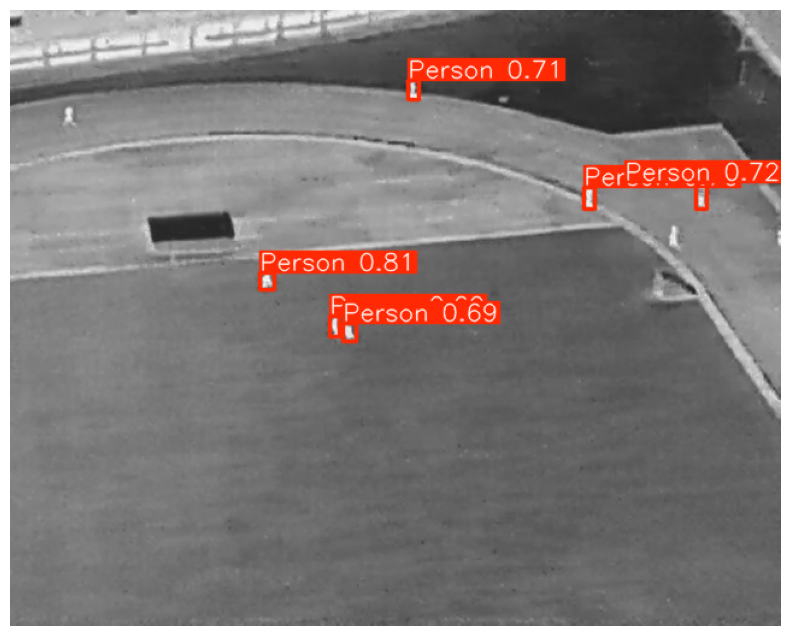

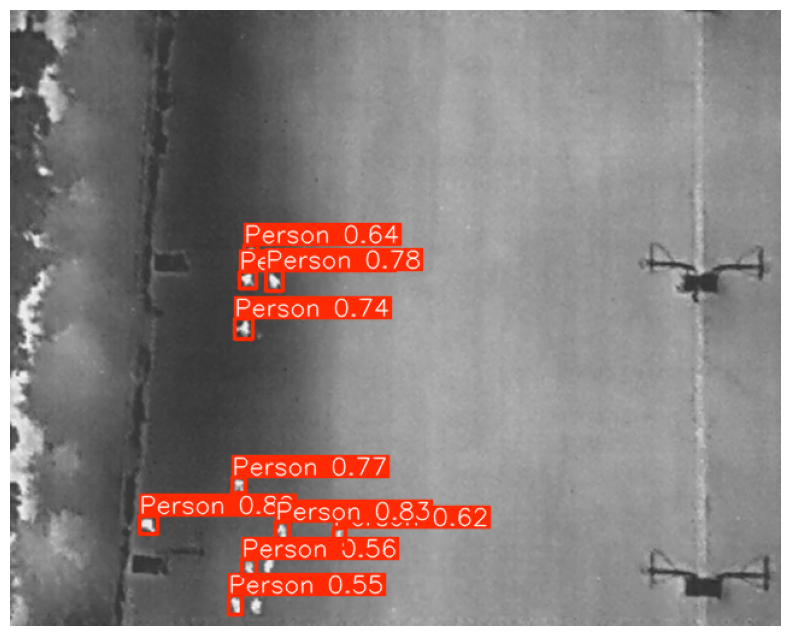

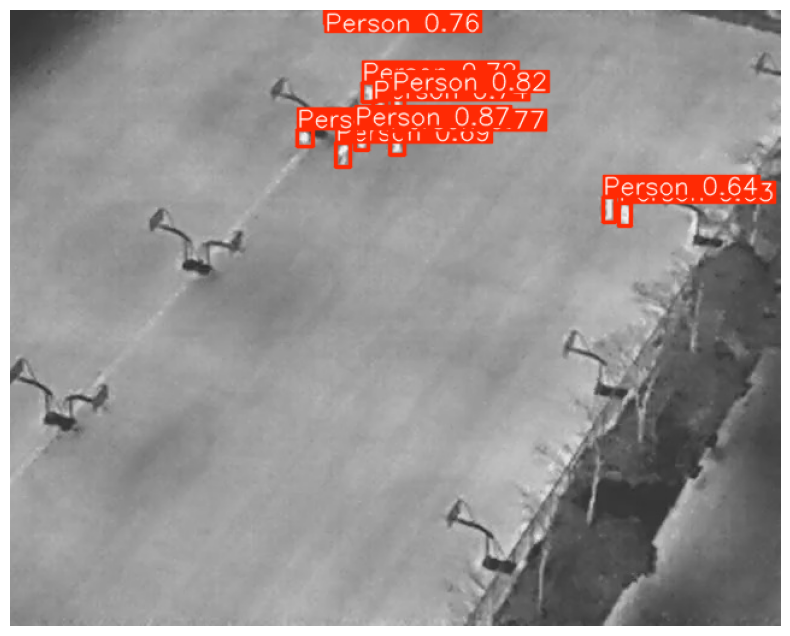

In [35]:
show_random_result(results)
show_random_result(results)
show_random_result(results)

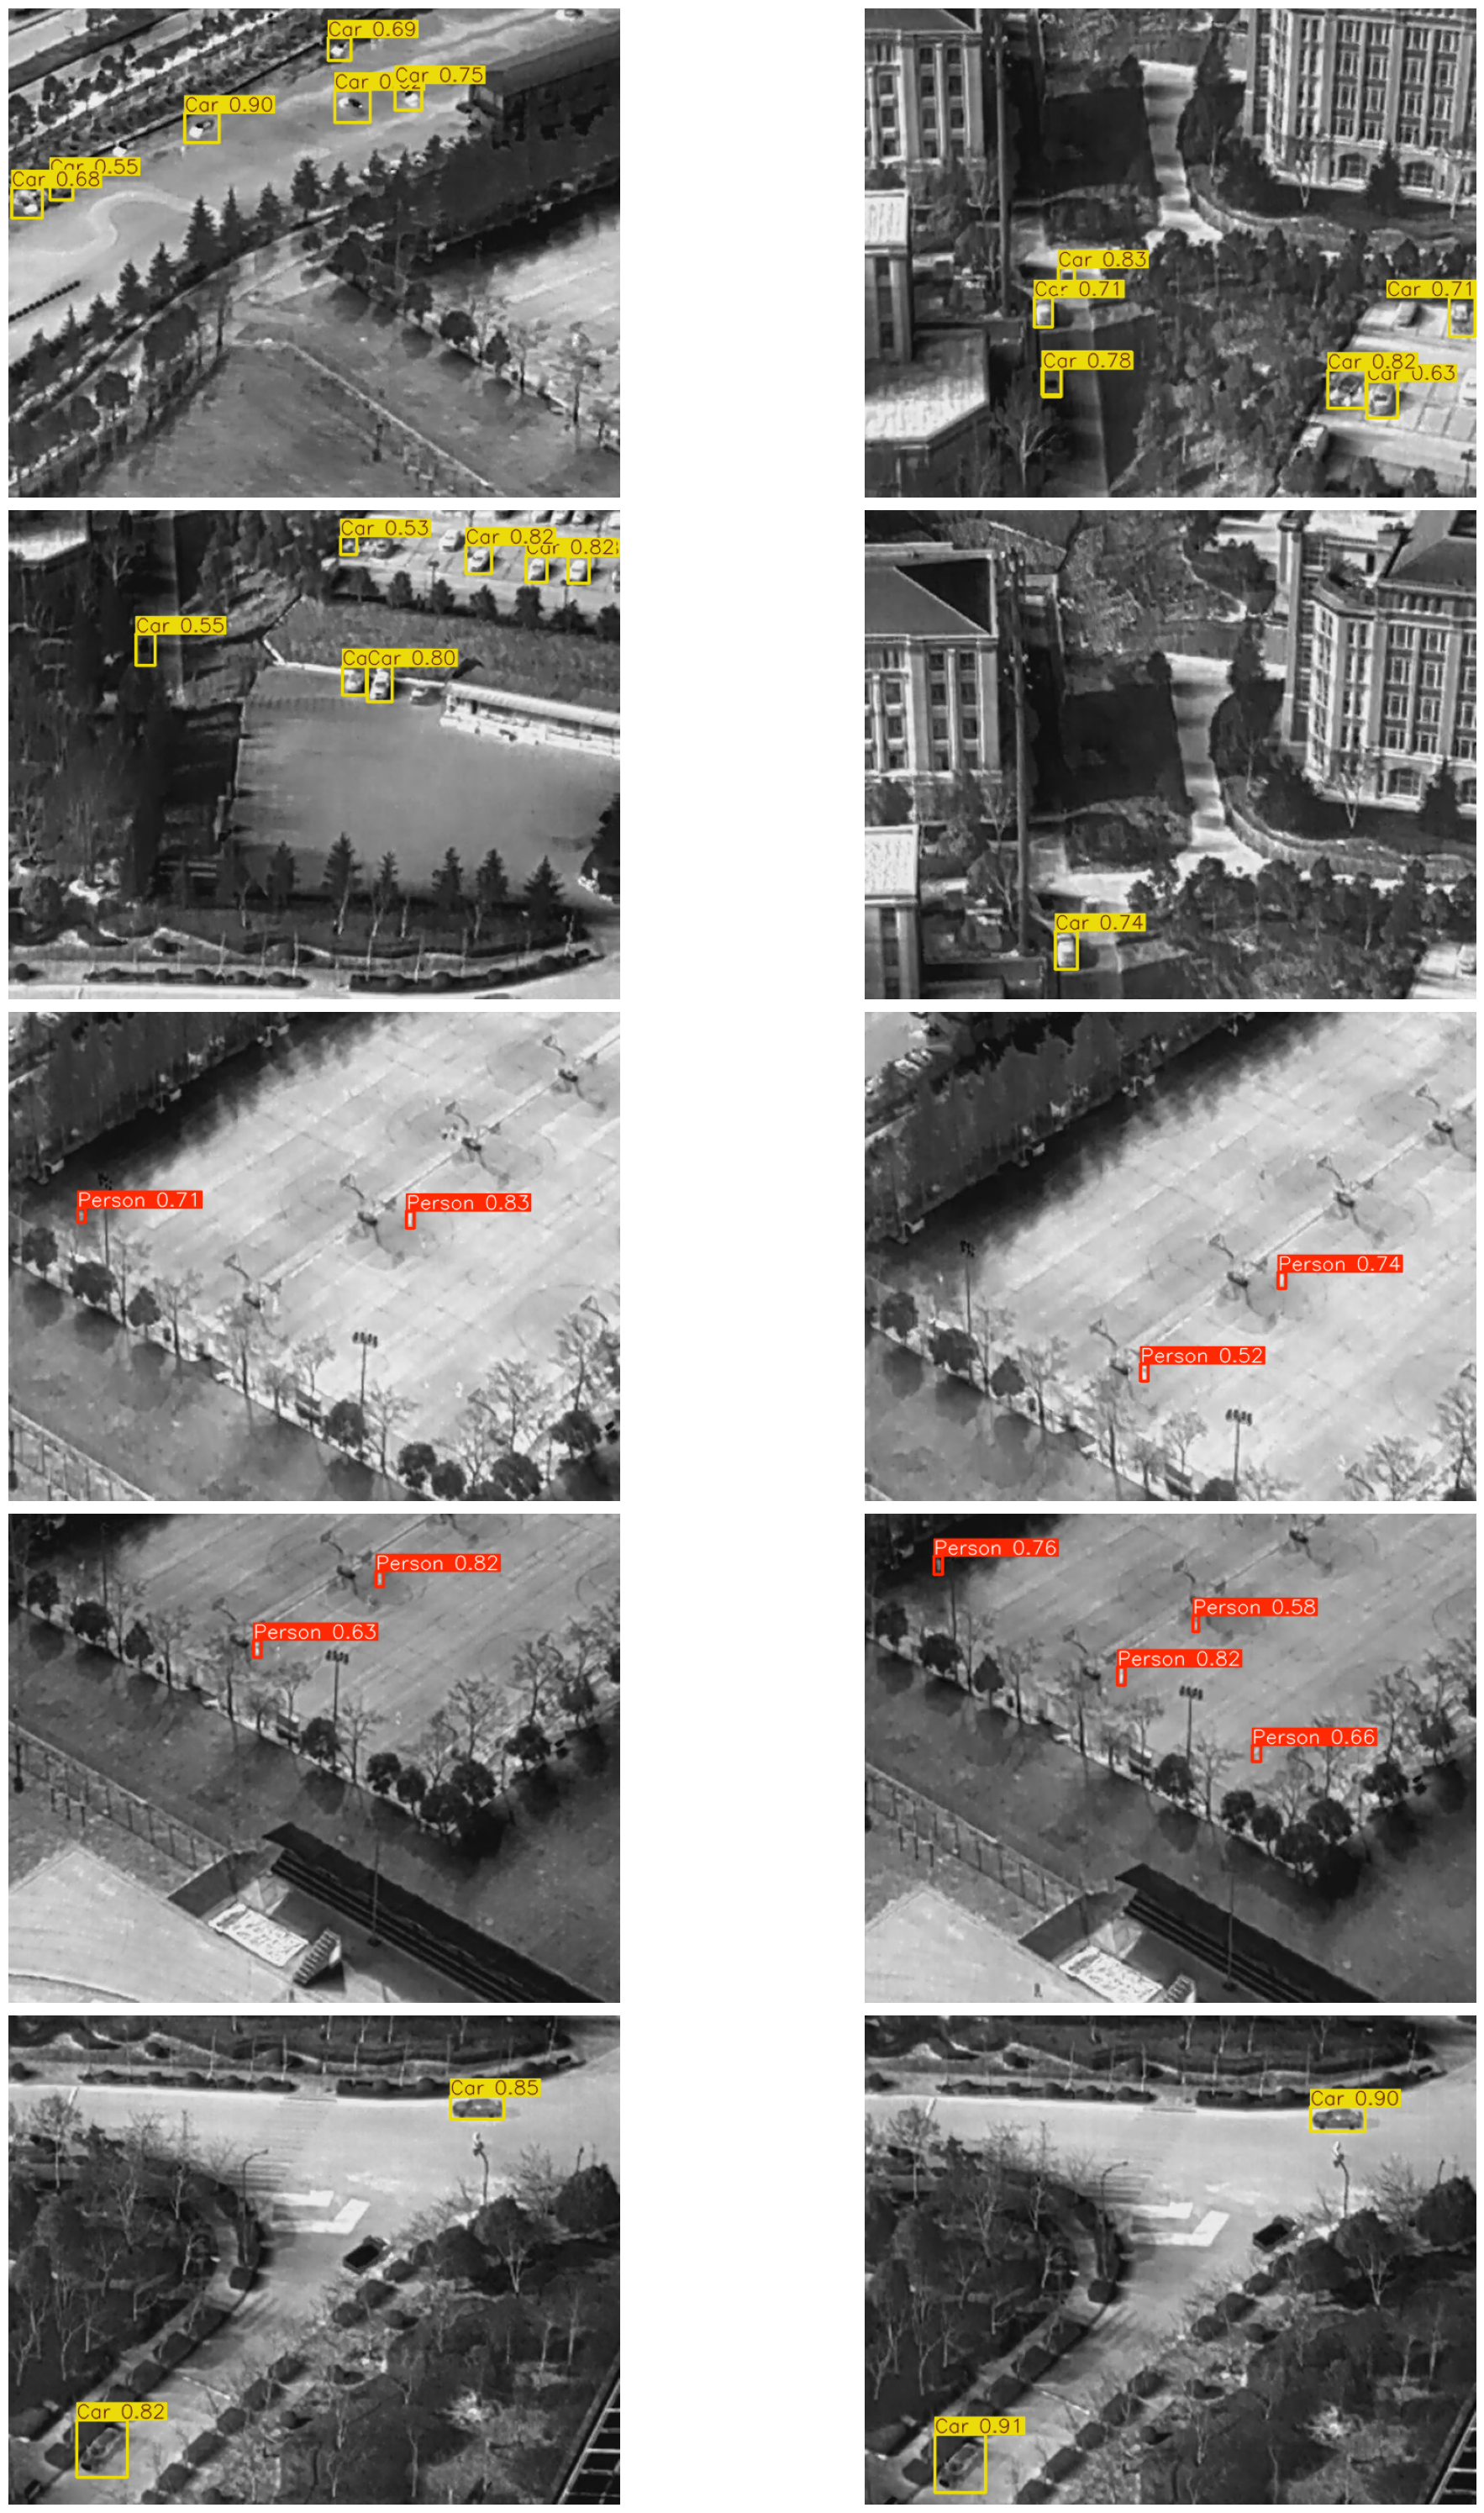

In [36]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Compare predictions with ground truth

In [37]:
ground_colors = [(255, 0, 0) for _ in range(len(classes))]

In [38]:
!ls runs/detect

predict  yolov10_mobilenetv2


In [39]:
# CELL 23: Export ONNX
success = best_model.export(format="onnx", imgsz=640, simplify=True)
print(f"Export ONNX: {success}")

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv10n_mobilenetv2 summary: 202 layers, 3,504,223 parameters, 0 gradients, 9.0 GFLOPs

PyTorch: starting from 'runs/detect/yolov10_mobilenetv2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (7.9 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.11.13 environment at: /usr
Resolved 25 packages in 307ms
 Downloaded onnxruntime-gpu
 Downloaded sympy
Prepared 6 packages in 2.90s
Uninstalled 2 packages in 162ms
Installed 6 packages in 52ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.74
 - protobuf==3.20.3
 + protobuf==6.33.1
 - sympy==1.13.1
 + sympy==1.14.0

requirements: AutoUpdate success ✅ 3.8s